In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

In [35]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)

dataset.data = dataset.data[:6000]
dataset.targets = dataset.targets[:6000]

train_set, val_set = torch.utils.data.random_split(dataset, [5000, 1000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)

test_set.data = test_set.data[:1000]
test_set.targets = test_set.targets[:1000]

train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

In [36]:
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data: ",len(test_loader))

Training data: 5000 Validation data: 1000 Test data:  1000


In [37]:
use_cuda = True
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [38]:
class DefenseTeacher(nn.Module):
    def __init__(self):
        super(DefenseTeacher, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [39]:
class DefenseStudent(nn.Module):
	def __init__(self):
		super(DefenseStudent, self).__init__()
		self.conv1 = nn.Conv2d(1, 16, 3, 1)
		self.conv2 = nn.Conv2d(16, 32, 3, 1)
		self.dropout1 = nn.Dropout2d(0.25)
		self.dropout2 = nn.Dropout2d(0.5)
		self.fc1 = nn.Linear(4608, 64)
		self.fc2 = nn.Linear(64, 10)

	def forward(self, x):
		x = self.conv1(x)
		x = F.relu(x)
		x = self.conv2(x)
		x = F.relu(x)
		x = F.max_pool2d(x, 2)
		x = self.dropout1(x)
		x = torch.flatten(x, 1)
		x = self.fc1(x)
		x = F.relu(x)
		x = self.dropout2(x)
		x = self.fc2(x)
		return x

In [40]:
def train_defense(model, device, model_loss, optimizer, scheduler, train_loader, val_loader, epochs=10):
    temp = 100
    
    validation_losses = []
    validation_accuracies = []
    
    train_losses = []
    train_accuracies = []
    
    # Training loop
    for epoch in range(epochs):
        
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)

            # Softmax with temperature
            output = output / temp
            output = F.log_softmax(output, dim=1)

            loss = model_loss(output, target)
            
            train_loss += loss.item()
            _, predicted = output.max(1)
            train_total += target.size(0)
            train_correct += predicted.eq(target).sum().item()
            
            loss.backward()
            optimizer.step()

        # Validation loop
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            model.eval()
            for batch_idx, (data, target) in enumerate(val_loader):
                data, target = data.to(device), target.to(device)
                output = model(data)
                output = output / temp
                output = F.log_softmax(output, dim=1)
                loss = model_loss(output, target)
                val_loss += loss.item()
                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()

        val_loss /= len(val_loader)
        train_loss /= len(train_loader)
        train_accuracy = 100. * train_correct / train_total
        accuracy = 100. * correct / total
        print('Epoch: {} Train Set: Average loss: {:.4f}, Validation set: Average loss: {:.4f}, Train Accuracy: {}/{} ({:.2f}%), Val Accuracy: {}/{} ({:.2f}%)'.format(
            epoch + 1, train_loss, val_loss, train_correct, train_total, train_accuracy, correct, total, accuracy))
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validation_losses.append(val_loss)
        validation_accuracies.append(accuracy)
        
        scheduler.step(val_loss)
        
    return train_losses, validation_losses


In [ ]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

/Users/loganfalzarano/anaconda3/envs/cv2024/lib/python3.8/site-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 Train Set: Average loss: 1.2366, Validation set: Average loss: 0.5340, Train Accuracy: 2952/5000 (59.04%), Val Accuracy: 847/1000 (84.70%)
Epoch: 2 Train Set: Average loss: 0.3743, Validation set: Average loss: 0.3662, Train Accuracy: 4445/5000 (88.90%), Val Accuracy: 900/1000 (90.00%)
Epoch: 3 Train Set: Average loss: 0.2882, Validation set: Average loss: 0.3667, Train Accuracy: 4571/5000 (91.42%), Val Accuracy: 904/1000 (90.40%)
Epoch: 4 Train Set: Average loss: 0.2384, Validation set: Average loss: 0.3218, Train Accuracy: 4655/5000 (93.10%), Val Accuracy: 921/1000 (92.10%)
Epoch: 5 Train Set: Average loss: 0.2084, Validation set: Average loss: 0.2670, Train Accuracy: 4683/5000 (93.66%), Val Accuracy: 925/1000 (92.50%)
Epoch: 6 Train Set: Average loss: 0.1746, Validation set: Average loss: 0.2915, Train Accuracy: 4736/5000 (94.72%), Val Accuracy: 922/1000 (92.20%)
Epoch: 7 Train Set: Average loss: 0.1504, Validation set: Average loss: 0.2797, Train Accuracy: 4785/5000 (95.70

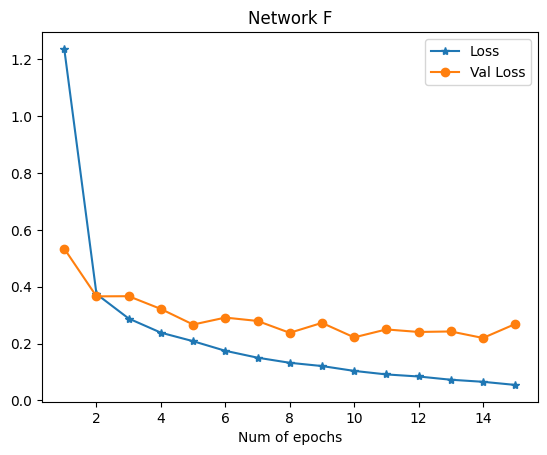

Epoch: 1 Train Set: Average loss: 1.4336, Validation set: Average loss: 0.6258, Train Accuracy: 2698/5000 (53.96%), Val Accuracy: 836/1000 (83.60%)
Epoch: 2 Train Set: Average loss: 0.4281, Validation set: Average loss: 0.3967, Train Accuracy: 4376/5000 (87.52%), Val Accuracy: 892/1000 (89.20%)
Epoch: 3 Train Set: Average loss: 0.3270, Validation set: Average loss: 0.3575, Train Accuracy: 4510/5000 (90.20%), Val Accuracy: 900/1000 (90.00%)
Epoch: 4 Train Set: Average loss: 0.2844, Validation set: Average loss: 0.3378, Train Accuracy: 4581/5000 (91.62%), Val Accuracy: 915/1000 (91.50%)
Epoch: 5 Train Set: Average loss: 0.2492, Validation set: Average loss: 0.3219, Train Accuracy: 4616/5000 (92.32%), Val Accuracy: 911/1000 (91.10%)
Epoch: 6 Train Set: Average loss: 0.2299, Validation set: Average loss: 0.3082, Train Accuracy: 4661/5000 (93.22%), Val Accuracy: 921/1000 (92.10%)
Epoch: 7 Train Set: Average loss: 0.2036, Validation set: Average loss: 0.2997, Train Accuracy: 4703/5000 (94.06

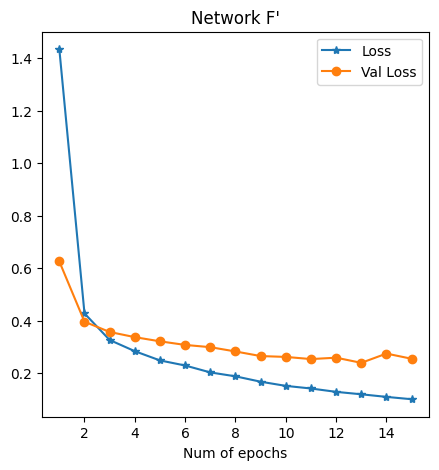

In [41]:
device, train_loader, val_loader, test_loader, epochs, Temp, epsilons = device, train_loader, val_loader, test_loader, 15, 100, [0.1, 0.2, 0.3, 0.4, 0.5]

#teacher model
teacher_model = DefenseTeacher().to(device)
optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=0.0001, betas=(0.9, 0.999))
teacher_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_teacher, mode='min', factor=0.1, patience=3)

#student model
student_model = DefenseStudent().to(device)
optimizer_student = optim.Adam(student_model.parameters(), lr=0.0001, betas=(0.9, 0.999))
student_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_student, mode='min', factor=0.1, patience=3)

criterion = nn.NLLLoss()

lossF, val_lossF = train_defense(teacher_model, device, criterion, optimizer_teacher, teacher_scheduler, train_loader, val_loader, epochs)

plt.plot(np.arange(1, epochs+1), lossF, "*-", label="Loss")
plt.plot(np.arange(1, epochs+1), val_lossF, "o-", label="Val Loss")
plt.title("Network F")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

# converting target labels to soft labels
for data in train_loader:
    input, label = data[0].to(device), data[1].to(device)
    softlabel = F.log_softmax(teacher_model(input), dim=1)
    data[1] = softlabel

lossF1, val_lossF1 = train_defense(student_model, device, criterion, optimizer_student, student_scheduler, train_loader, val_loader, epochs)
fig = plt.figure(figsize=(5, 5))
plt.plot(np.arange(1, epochs+1), lossF1, "*-", label="Loss")
plt.plot(np.arange(1, epochs+1), val_lossF1, "o-", label="Val Loss")
plt.title("Network F'")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

# model = NetF1().to(device)
# model.load_state_dict(modelF1.state_dict())
# for attack in ("fgsm", "ifgsm", "mifgsm"):
#     accuracies = []
#     examples = []
#     for eps in epsilons:
#         acc, ex = test(model, device, test_loader, eps, 1, "fgsm")
#         accuracies.append(acc)
#         examples.append(ex)

#     plt.figure(figsize=(5, 5))
#     plt.plot(epsilons, accuracies, "*-")
#     plt.title(attack)
#     plt.xlabel("Epsilon")
#     plt.ylabel("Accuracy")
#     plt.show()

#     cnt = 0
#     plt.figure(figsize=(8, 10))
#     for i in range(len(epsilons)):
#         for j in range(len(examples[i])):
#             cnt += 1
#             plt.subplot(len(epsilons), len(examples[0]), cnt)
#             plt.xticks([], [])
#             plt.yticks([], [])
#             if j == 0:
#                 plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
#             orig, adv, ex = examples[i][j]
#             plt.title("{} -> {}".format(orig, adv))
#             plt.imshow(ex, cmap="gray")
#     plt.tight_layout()
#     plt.show()


In [ ]:
# make a prediction on the first 5 test images
counter = 0
for (X, y) in train_loader:
    X, y = X.to(device), y.to(device)
    output = student_model(X)
    _, predicted = torch.max(output, 1)
    print("Actual: ", y)
    #plot the probability distribution as a bar chart
    plt.bar(np.arange(10), output[0].cpu().detach())
    plt.title("Prediction: {}".format(predicted[0]))
    plt.show()
    counter += 1
    if counter == 5:
        break
    
    


In [13]:
def create_fgsm_adversarial_example(model, criterion, X, y, epsilon):
    X.requires_grad = True
    model.zero_grad()
    
    X = X.to(device)
    X.retain_grad()
    y = y.to(device)
    
    output = model(X)
    model_prediction_unperturbed = output.argmax(dim=1)
    prediction_confidence = F.softmax(output, dim=1).max()
    loss = criterion(output, y)
    loss.backward()
    
    x_grad = X.grad
    x_adv = X + epsilon * x_grad.sign()
    
    #clamp
    x_adv = torch.clamp(x_adv, 0, 1)
    return model_prediction_unperturbed, prediction_confidence, x_adv

In [14]:
def evaluate_model_on_adversarial_input(model, model_criterion, test_dataloader, epsilon=0.1):
    
    #set batch size of 1
    test_dataloader = torch.utils.data.DataLoader(test_dataloader.dataset, batch_size=1, shuffle=False)
    
    raw_image_prections = []
    adv_image_predictions = []
    true_labels = []
    
    for X, y in test_dataloader:
        
        X = X.to(device)
        y = y.to(device)
        
        true_labels.append(y)
        
        #get the predictions on the raw image
        raw_image_prediction = model(X)
        _, raw_image_predicted = torch.max(raw_image_prediction.data, 1)
        raw_image_prections.append(raw_image_predicted)
        
        #create adversarial example
        _, _, x_adv = create_fgsm_adversarial_example(model, model_criterion, X, y, epsilon)
        
        #get the predictions on the adversarial image
        adv_image_prediction = model(x_adv)
        _, adv_image_predicted = torch.max(adv_image_prediction.data, 1)
        adv_image_predictions.append(adv_image_predicted)
            
    #concatenate the predictions
    raw_image_prections = torch.cat(raw_image_prections)
    adv_image_predictions = torch.cat(adv_image_predictions)
    true_labels = torch.cat(true_labels)
                
    return raw_image_prections, adv_image_predictions, true_labels

In [66]:
raw_image_prections, adv_image_predictions, true_labels = evaluate_model_on_adversarial_input(model, criterion, test_loader, epsilon=0.5)

/Users/loganfalzarano/anaconda3/envs/cv2024/lib/python3.8/site-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [67]:
#calculate the accuracy on raw and adversarial examples

#convert the predictions to numpy
raw_image_prections = raw_image_prections.cpu().numpy()
adv_image_predictions = adv_image_predictions.cpu().numpy()
true_labels = true_labels.cpu().numpy()

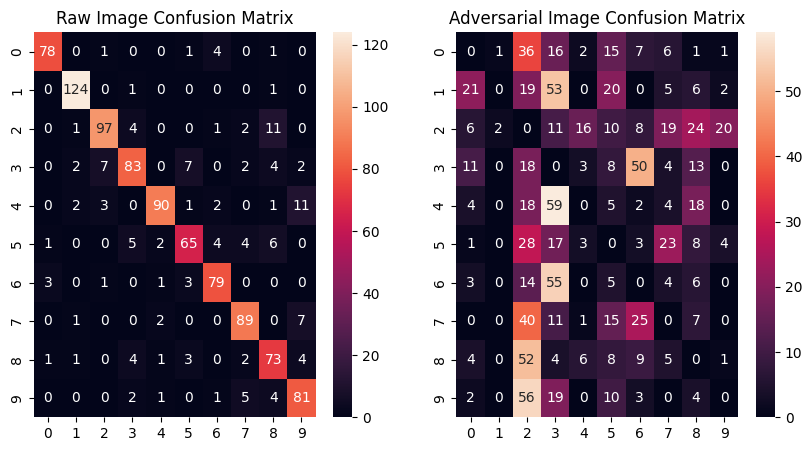

In [68]:
#calculate confusion matrices
from sklearn.metrics import confusion_matrix
raw_image_confusion_matrix = confusion_matrix(true_labels, raw_image_prections)
adv_image_confusion_matrix = confusion_matrix(true_labels, adv_image_predictions)

#plot the confusion matrices
import seaborn as sns


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(raw_image_confusion_matrix, annot=True, fmt='g')
plt.title('Raw Image Confusion Matrix')
plt.subplot(1, 2, 2)
sns.heatmap(adv_image_confusion_matrix, annot=True, fmt='g')
plt.title('Adversarial Image Confusion Matrix')
plt.show()


In [69]:
#caculate the accuracy on adversarial examples
adv_image_accuracy = (adv_image_predictions == true_labels).mean()
print('Accuracy on Adversarial Examples: ', adv_image_accuracy)

Accuracy on Adversarial Examples:  0.0


In [47]:
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      init_pred = output.max(1, keepdim=True)[1] 
      if init_pred.item() != target.item():
          continue
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data
      
      def fgsm_attack(input,epsilon,data_grad):
        pert_out = input + epsilon*data_grad.sign()
        pert_out = torch.clamp(pert_out, 0, 1)
        return pert_out

      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
    #   elif attack == "ifgsm":
    #     perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    #   elif attack == "mifgsm":
    #     perturbed_data = mifgsm_attack(data,epsilon,data_grad)
        
      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
          correct += 1
          if (epsilon == 0) and (len(adv_examples) < 5):
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
      else:
          if len(adv_examples) < 5:
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc, adv_examples


In [51]:
model = DefenseStudent().to(device)

st = torch.load("modelF1.pt")

model.load_state_dict(st)

<All keys matched successfully>

In [52]:


epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
      acc, ex = test(model, device,test_loader,eps,attack)
      accuracies.append(acc)
      examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()

  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
      for j in range(len(examples[i])):
          cnt += 1
          plt.subplot(len(epsilons),len(examples[0]),cnt)
          plt.xticks([], [])
          plt.yticks([], [])
          if j == 0:
              plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
          orig,adv,ex = examples[i][j]
          plt.title("{} -> {}".format(orig, adv))
          plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

/Users/loganfalzarano/anaconda3/envs/cv2024/lib/python3.8/site-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


UnboundLocalError: local variable 'perturbed_data' referenced before assignment

Epsilon: 0	Test Accuracy = 595 / 1000 = 0.595
Epsilon: 0.007	Test Accuracy = 568 / 1000 = 0.568
Epsilon: 0.01	Test Accuracy = 576 / 1000 = 0.576
Epsilon: 0.02	Test Accuracy = 553 / 1000 = 0.553
Epsilon: 0.03	Test Accuracy = 532 / 1000 = 0.532
Epsilon: 0.05	Test Accuracy = 484 / 1000 = 0.484
Epsilon: 0.1	Test Accuracy = 340 / 1000 = 0.34
Epsilon: 0.2	Test Accuracy = 133 / 1000 = 0.133
Epsilon: 0.3	Test Accuracy = 47 / 1000 = 0.047


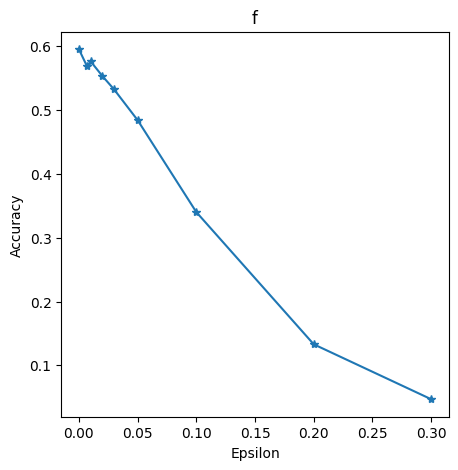

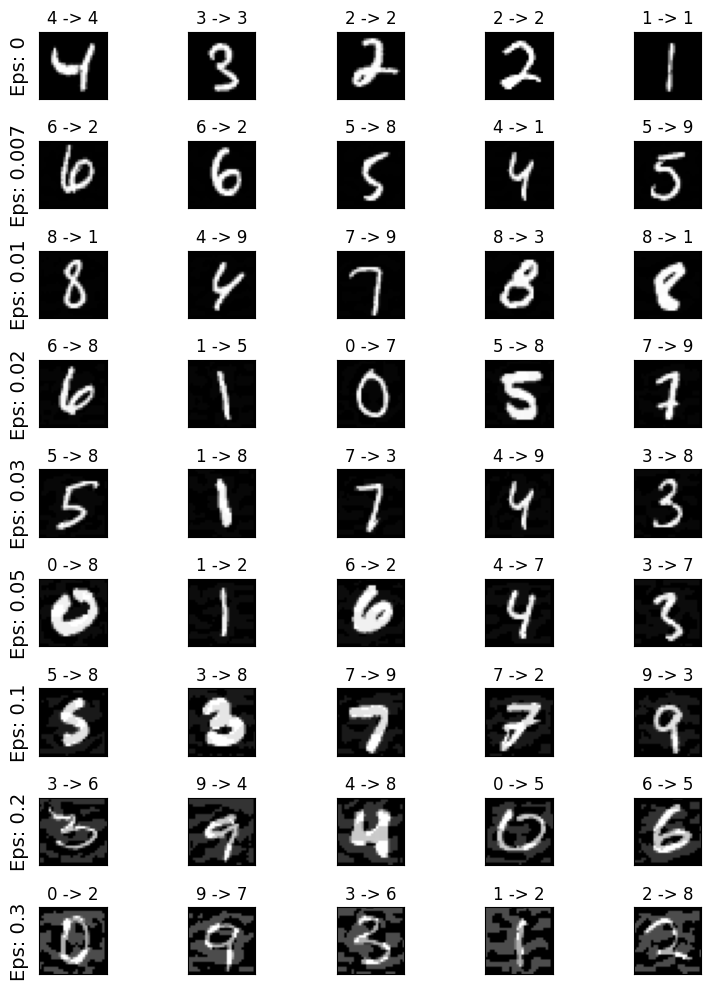

Epsilon: 0	Test Accuracy = 571 / 1000 = 0.571
Epsilon: 0.007	Test Accuracy = 565 / 1000 = 0.565
Epsilon: 0.01	Test Accuracy = 558 / 1000 = 0.558
Epsilon: 0.02	Test Accuracy = 549 / 1000 = 0.549
Epsilon: 0.03	Test Accuracy = 535 / 1000 = 0.535
Epsilon: 0.05	Test Accuracy = 496 / 1000 = 0.496
Epsilon: 0.1	Test Accuracy = 349 / 1000 = 0.349
Epsilon: 0.2	Test Accuracy = 138 / 1000 = 0.138
Epsilon: 0.3	Test Accuracy = 36 / 1000 = 0.036


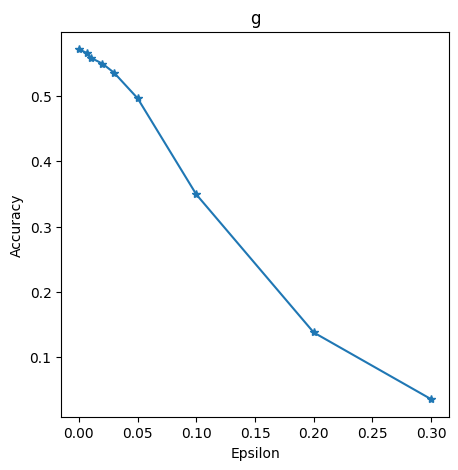

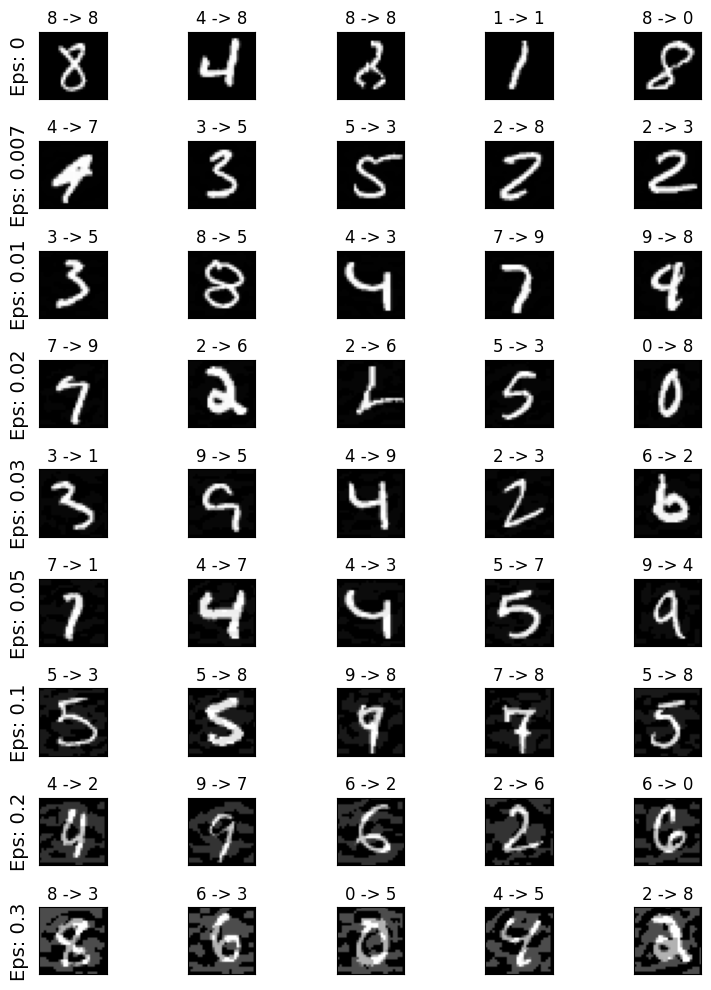

Epsilon: 0	Test Accuracy = 584 / 1000 = 0.584
Epsilon: 0.007	Test Accuracy = 571 / 1000 = 0.571
Epsilon: 0.01	Test Accuracy = 571 / 1000 = 0.571
Epsilon: 0.02	Test Accuracy = 520 / 1000 = 0.52
Epsilon: 0.03	Test Accuracy = 556 / 1000 = 0.556
Epsilon: 0.05	Test Accuracy = 482 / 1000 = 0.482
Epsilon: 0.1	Test Accuracy = 349 / 1000 = 0.349
Epsilon: 0.2	Test Accuracy = 137 / 1000 = 0.137
Epsilon: 0.3	Test Accuracy = 43 / 1000 = 0.043


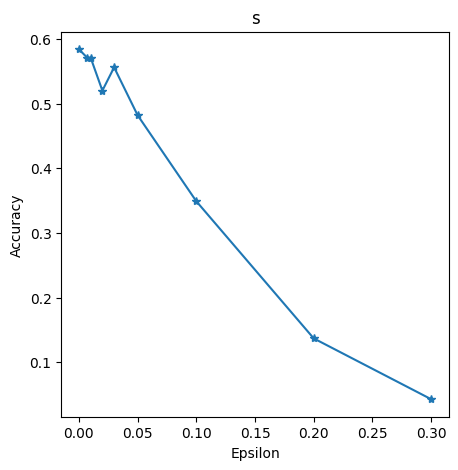

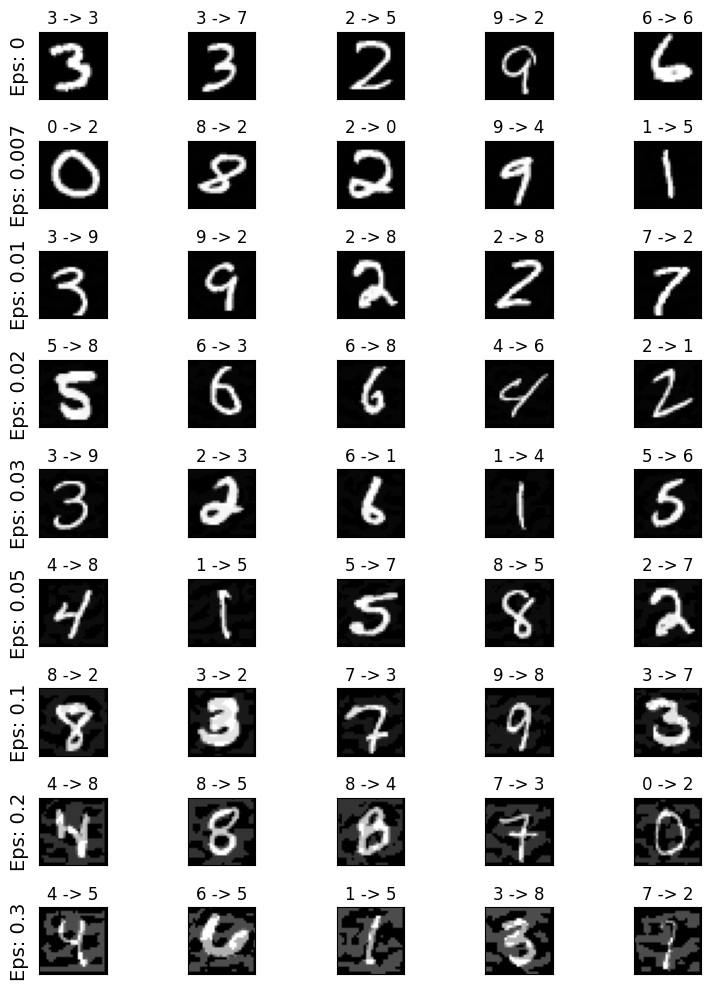

Epsilon: 0	Test Accuracy = 568 / 1000 = 0.568
Epsilon: 0.007	Test Accuracy = 582 / 1000 = 0.582
Epsilon: 0.01	Test Accuracy = 543 / 1000 = 0.543
Epsilon: 0.02	Test Accuracy = 574 / 1000 = 0.574
Epsilon: 0.03	Test Accuracy = 530 / 1000 = 0.53
Epsilon: 0.05	Test Accuracy = 455 / 1000 = 0.455
Epsilon: 0.1	Test Accuracy = 350 / 1000 = 0.35
Epsilon: 0.2	Test Accuracy = 126 / 1000 = 0.126
Epsilon: 0.3	Test Accuracy = 36 / 1000 = 0.036


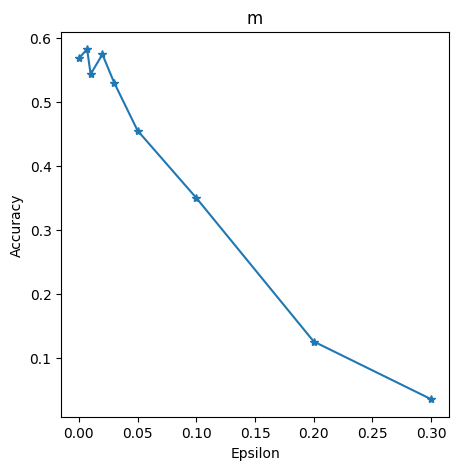

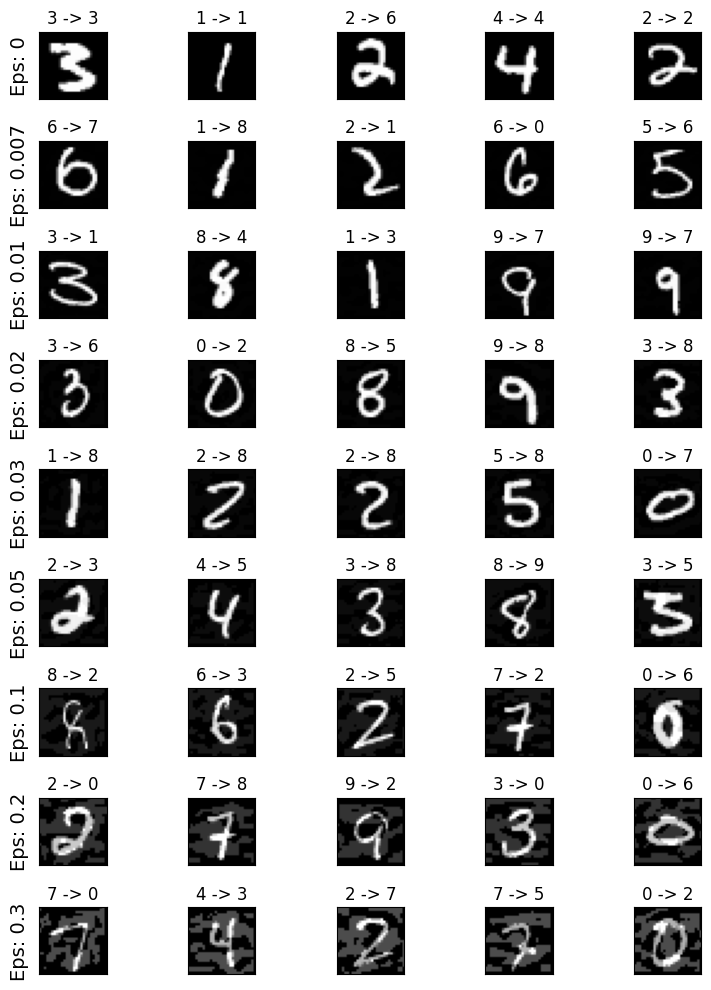

In [45]:
model = DefenseTeacher().to(device)
model.load_state_dict(teacher_model.state_dict())

epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
      acc, ex = test(model, device,test_loader,eps,"fgsm")
      accuracies.append(acc)
      examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()

  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
      for j in range(len(examples[i])):
          cnt += 1
          plt.subplot(len(epsilons),len(examples[0]),cnt)
          plt.xticks([], [])
          plt.yticks([], [])
          if j == 0:
              plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
          orig,adv,ex = examples[i][j]
          plt.title("{} -> {}".format(orig, adv))
          plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()